In [37]:
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from PIL import Image
import os
from IPython import display
import time
import matplotlib.pyplot as plt

from tensorflow.keras import layers

In [3]:
path = os.getcwd()+"/dataset"
# for num_image, image in enumerate(os.listdir(path)):
#     os.rename(path+'/'+image, path+'/'+str(num_image)+'.jpg')

In [4]:
X = []
for num_image, image in enumerate(os.listdir(path)):
    image = Image.open(path+'/'+image).resize((128,128), Image.ANTIALIAS)
    image_array = np.asarray(image)
    if image_array.shape == (128, 128, 3):
        X.append(image_array)
X = np.array(X)

C:\Users\thoma\AppData\Local\Temp\ipykernel_84\2846918111.py:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = Image.open(path+'/'+image).resize((128,128), Image.ANTIALIAS)


In [5]:
X.shape

(4315, 128, 128, 3)

In [6]:
X_train, X_test,_, _ = train_test_split( X, X, test_size=0.2, random_state=42)

## DCGAN

In [26]:
train_images = (X_train - 127.5) / 127.5

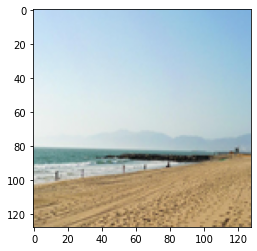

In [56]:
plt.imshow((train_images[0] + 1)/2)

In [27]:
BUFFER_SIZE = 60000
BATCH_SIZE = 64

In [28]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [57]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(16*16*64, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((16, 16, 64)))
    assert model.output_shape == (None, 16, 16, 64)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(32, 3, strides=2, padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(16, 3, strides=2, padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, 3, strides=2, padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3)

    return model


def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, 3, strides=2, padding='same',
                                     input_shape=[128, 128, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(32, 5, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [62]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [59]:
@tf.function
def train_step(images):
    
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [60]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False).numpy()

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i] + 1)/2)
      plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [65]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)    

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                             epoch + 1 + 200,
                             seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


In [ ]:
discriminator = make_discriminator_model()
generator = make_generator_model()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
EPOCHS = 1000

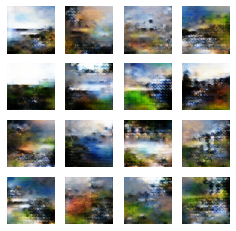

Time for epoch 255 is 5869.30840587616 sec


In [ ]:
train(train_dataset, EPOCHS)

In [67]:
discriminator.save("discriminator")
generator.save("generator")

INFO:tensorflow:Assets written to: discriminator\assets


INFO:tensorflow:Assets written to: discriminator\assets


INFO:tensorflow:Assets written to: generator\assets


INFO:tensorflow:Assets written to: generator\assets
